In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator
from ta.volatility import BollingerBands
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import datetime

In [8]:
# Project time frame
start_date = "2020-01-01"
end_date = "2025-05-01"

# Benchmark index
benchmark_symbol = "^GSPC"

# Top 10 symbols from each sector (replace with your actual tickers if needed)
sectors = {
    # "Technology": ["AAPL"],
    "Technology": ['AAPL', 'MSFT', 'AMZN', 'NFLX', 'MRNA', 'JNJ', 'ILMN', 'NEE', 'TSLA', 'FSLR'],
    "Benchmark": [benchmark_symbol]
}

# Flatten list of all tickers
all_symbols = [symbol for group in sectors.values() for symbol in group]

### Load from CSV

In [9]:
# Load dataset from CSV
import os

if os.path.exists("stock_sector_data.csv"):
    stock_df = pd.read_csv("stock_sector_data.csv", parse_dates=["Date"])
    print("Loaded dataset from CSV.")
else:
    print("CSV file not found. Please run the download step.")
    
# Drop any rows that are not in sectors dictionary
stock_df = stock_df[stock_df["Symbol"].isin(all_symbols)]
    

# Drop any rows with symbol that match the benchmark symbol
# stock_df = stock_df[stock_df["Symbol"] != benchmark_symbol]


Loaded dataset from CSV.


### Feature Engineering — Add Technical Indicators


In [10]:
def add_technical_indicators(df):
    result = []

    for symbol in df["Symbol"].unique():
        sub = df[df["Symbol"] == symbol].sort_values("Date").copy()

        # Momentum: past 1-week and 4-week returns
        # sub["Return_1w"] = sub["Close"].pct_change(1*7)
        sub["Return_4w"] = sub["Close"].pct_change(4*7)

        # Volatility: Rolling std dev
        sub["Volatility_4w"] = sub["Close"].rolling(window=4*7).std()
        
        # Moving averages
        # sub['MA5'] = sub['Close'].rolling(window=5*7).mean()
        # sub['MA20'] = sub['Close'].rolling(window=20*7).mean()
        sub['MA50'] = sub['Close'].rolling(window=50*7).mean()
        
        # Volume indicators
        sub['Volume_Change'] = sub['Volume'].pct_change(periods=7)
        sub['Volume_MA5'] = sub['Volume'].rolling(window=5*7).mean()
        
        # MACD
        sub["MACD"] = MACD(close=sub["Close"]).macd()
        sub["MACD_Signal"] = MACD(close=sub["Close"]).macd_signal()

        # RSI
        sub["RSI"] = RSIIndicator(close=sub["Close"], window=14).rsi()

        # SMAbenchmark_symbol
        # Bollinger BandsBollinger Bands
        bb = BollingerBands(close=sub["Close"], window=20)
        sub["BB_Upper"] = bb.bollinger_hband()
        sub["BB_Lower"] = bb.bollinger_lband()

        result.append(sub)

    features_df = pd.concat(result).reset_index(drop=True)
    features_df.drop(columns=["Low", "High", "Open"], inplace=True)
    return features_df
indicator_with_feature = add_technical_indicators(stock_df[stock_df["Symbol"] == benchmark_symbol])
features_df = add_technical_indicators(stock_df[stock_df["Symbol"] != benchmark_symbol])
features_df = features_df.dropna()
features_df.head()


,Date,Close,Volume,Symbol,Sector,Return_4w,Volatility_4w,MA50,Volume_Change,Volume_MA5,MACD,MACD_Signal,RSI,BB_Upper,BB_Lower
349,2016-05-23,22.039343,152074400.0,AAPL,Choosen,-0.134085,1.465270,25.737764,-0.501818,1.716042e+08,-0.475991,-0.639397,48.824621,22.754475,20.281845
350,2016-05-24,22.375320,140560800.0,AAPL,Choosen,-0.121355,1.332161,25.732297,-0.208426,1.725826e+08,-0.379655,-0.587449,53.500443,22.289014,20.614323
351,2016-05-25,22.768429,152675200.0,AAPL,Choosen,-0.087606,1.227005,25.729909,-0.376936,1.739272e+08,-0.268493,-0.523657,58.301174,22.441463,20.516543
352,2016-05-26,22.948984,225324800.0,AAPL,Choosen,-0.060092,1.156410,25.728030,0.200659,1.767305e+08,-0.163937,-0.451713,60.327151,22.706008,20.392647
353,2016-05-27,22.935270,145364800.0,AAPL,Choosen,-0.055645,1.088316,25.725166,-0.136017,1.781887e+08,-0.081245,-0.377620,60.088351,22.928351,20.334343


### Create Outperformance Label

In [11]:
def create_outperformance_labels(features_df, benchmark_df, indicator_with_feature):
    # list all features from the features_df
    feature_columns = features_df.columns.tolist()
    print("Feature columns:", feature_columns)
    print("Benchmark columns:", indicator_with_feature.columns.tolist())
    
    for feature in feature_columns:
        if feature not in ["Date", "Symbol", "Benchmark_Return_Next", "Benchmark_Return"] and features_df[feature].dtype != 'object':
            if feature in indicator_with_feature.columns:
                features_df[f"{feature}_Pct_Difference"] = (features_df[feature] - indicator_with_feature[feature].shift(1)) / indicator_with_feature[feature].shift(1)
            else:
                print(f"Warning: Feature '{feature}' not found in indicator_with_feature. Skipping.")
    
    # Calculate future return for S&P 500
    benchmark_df["Benchmark_Return_Next"] = benchmark_df["Close"].pct_change().shift(-1)

    # Ensure 'Date' columns are of the same type
    features_df["Date"] = pd.to_datetime(features_df["Date"])
    benchmark_df["Date"] = pd.to_datetime(benchmark_df["Date"])

    # Merge benchmark return into stock data
    df = features_df.merge(benchmark_df[["Date", "Benchmark_Return_Next"]], on="Date", how="left")
    
    # Calculate benchmark return this week
    df["Benchmark_Return"] = df["Benchmark_Return_Next"].shift(1)

    # Calculate stock return this week and next week
    price_col = "Adj Close" if "Adj Close" in df.columns else "Close"
    df["Stock_Return_Next"] = df.groupby("Symbol")[price_col].pct_change().shift(-1)
    df["Stock_Return"] = df["Stock_Return_Next"].shift(1)
    
    df.dropna(inplace=True)

    # Label = 1 if stock outperforms benchmark, else 0
    df["Label"] = (df["Stock_Return_Next"] > df["Benchmark_Return_Next"]).astype(int)

    return df

# Load benchmark data from CSV
benchmark_df = pd.read_csv("stock_sector_data.csv", usecols=["Date", "Symbol", "Close"])
benchmark_df = benchmark_df[benchmark_df["Symbol"] == benchmark_symbol].reset_index(drop=True)

labeled_df = create_outperformance_labels(features_df, benchmark_df, indicator_with_feature)
labeled_df.tail()


Feature columns: ['Date', 'Close', 'Volume', 'Symbol', 'Sector', 'Return_4w', 'Volatility_4w', 'MA50', 'Volume_Change', 'Volume_MA5', 'MACD', 'MACD_Signal', 'RSI', 'BB_Upper', 'BB_Lower']
Benchmark columns: ['Date', 'Close', 'Volume', 'Symbol', 'Sector', 'Return_4w', 'Volatility_4w', 'MA50', 'Volume_Change', 'Volume_MA5', 'MACD', 'MACD_Signal', 'RSI', 'BB_Upper', 'BB_Lower']


,Date,Close,Volume,Symbol,Sector,Return_4w,Volatility_4w,MA50,Volume_Change,Volume_MA5,...,MACD_Pct_Difference,MACD_Signal_Pct_Difference,RSI_Pct_Difference,BB_Upper_Pct_Difference,BB_Lower_Pct_Difference,Benchmark_Return_Next,Benchmark_Return,Stock_Return_Next,Stock_Return,Label
2242,2025-04-23,204.332062,52929200.0,AAPL,Choosen,-0.024227,14.139634,209.314272,-0.394651,6.878157e+07,...,-0.949405,-0.939454,0.118322,-0.960462,-0.964913,0.020259,0.016661,0.018426,0.024332,0
2243,2025-04-24,208.097107,47311000.0,AAPL,Choosen,-0.023982,14.083361,209.371711,-0.533205,6.878396e+07,...,-0.953842,-0.941990,0.083181,-0.960410,-0.964908,0.007373,0.020259,0.004367,0.018426,0
2244,2025-04-25,209.005920,38222300.0,AAPL,Choosen,-0.022056,14.020274,209.430102,-0.255563,6.858544e+07,...,-0.954848,-0.943933,0.007821,-0.960563,-0.964830,0.000641,0.007373,0.004109,0.004367,1
2245,2025-04-28,209.864792,38743100.0,AAPL,Choosen,-0.011989,13.986714,209.487288,-0.351389,6.837028e+07,...,-0.954946,-0.945322,-0.009388,-0.960562,-0.964844,0.005802,0.000641,0.005092,0.004109,0
2246,2025-04-29,210.933395,36827600.0,AAPL,Choosen,-0.018723,13.912902,209.552661,-0.282593,6.736332e+07,...,-0.956570,-0.946503,0.002088,-0.960842,-0.964696,0.001480,0.005802,0.006108,0.005092,1


### Train/Test Split & Preprocessing

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data(df):
    # Drop rows where the label is missing (NaN due to shifting)
    df = df.dropna(subset=["Label"])
    
    # Fill remaining missing values with median (safe for numeric features)
    df = df.fillna(df.median(numeric_only=True))

    # Keep only numeric feature columns
    # exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']
    exclude_cols = ['Date', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']
    feature_columns = [col for col in df.columns if col not in exclude_cols and df[col].dtype != 'object']
    
    X = df[feature_columns]
    y = df["Label"].astype(int)  # Ensure label is int

    # Optional: Scaling (not strictly necessary for Random Forest)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

In [13]:
# Split the data: train up to 2023, test after
# train_data = labeled_df[labeled_df["Date"] < "2024-11-01"]
# test_data = labeled_df[labeled_df["Date"] >= "2024-11-01"]
train_data, test_data = train_test_split(labeled_df, test_size=0.2, random_state=42, stratify=labeled_df["Label"])

X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

In [14]:
# Shape of the data
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training data shape: (1796, 26), Labels shape: (1796,)
Testing data shape: (450, 26), Labels shape: (450,)


### Train Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation: Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.43      0.46       216
           1       0.53      0.58      0.55       234

    accuracy                           0.51       450
   macro avg       0.51      0.51      0.50       450
weighted avg       0.51      0.51      0.51       450



### Feature Importance Plot

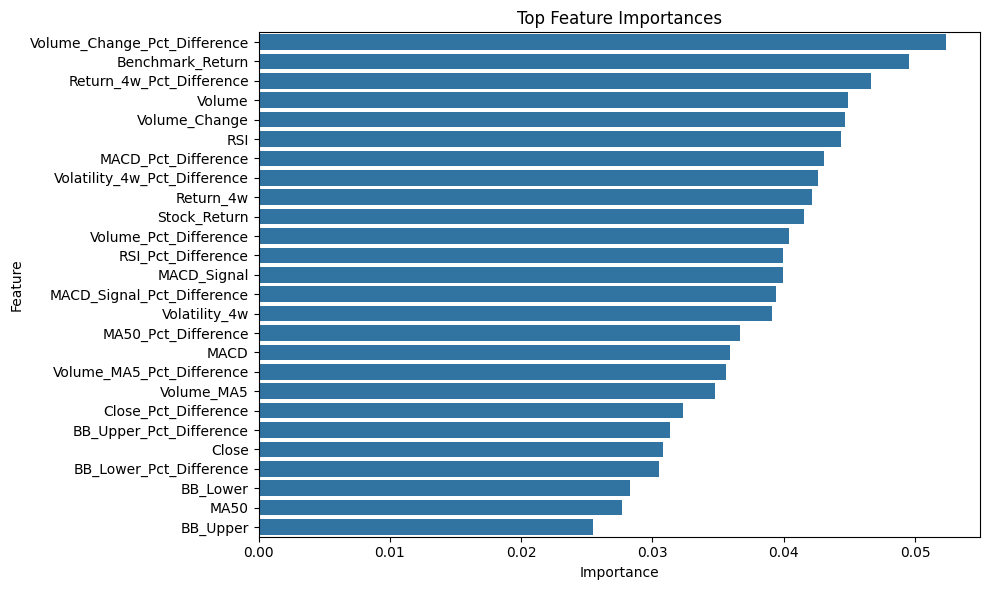

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

exclude_cols = ['Date', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']

# Get feature importances and names
feature_columns = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']
importances = rf_model.feature_importances_

# Create DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()

In [17]:
top_10_features = feat_imp_df.nlargest(10, 'Importance')['Feature'].tolist()
top_10_features

['Volume_Change_Pct_Difference',
 'Benchmark_Return',
 'Return_4w_Pct_Difference',
 'Volume',
 'Volume_Change',
 'RSI',
 'MACD_Pct_Difference',
 'Volatility_4w_Pct_Difference',
 'Return_4w',
 'Stock_Return']

In [18]:
top_6_features = feat_imp_df.nlargest(6, 'Importance')['Feature'].tolist()
top_6_features

['Volume_Change_Pct_Difference',
 'Benchmark_Return',
 'Return_4w_Pct_Difference',
 'Volume',
 'Volume_Change',
 'RSI']

### Correlation Analysis

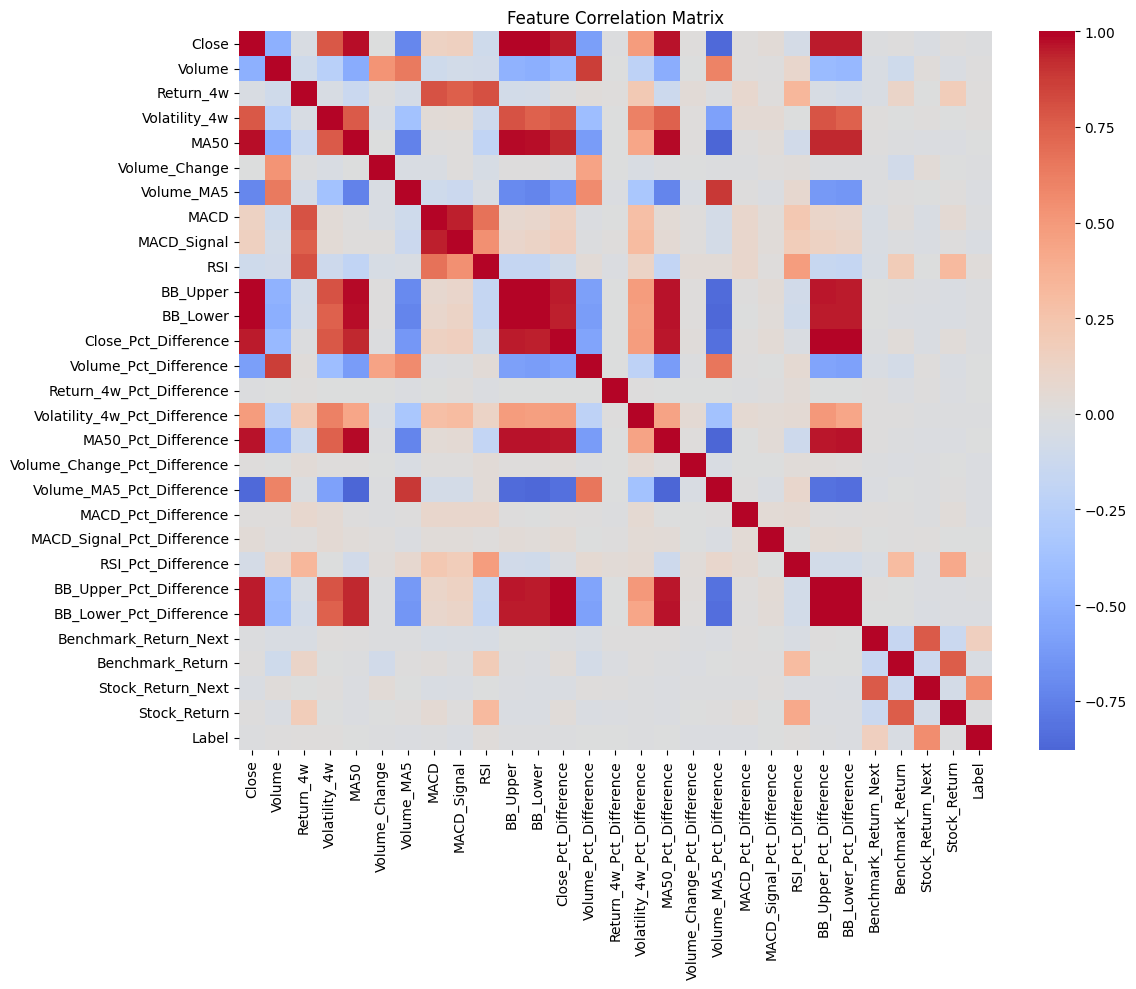

In [19]:
# Compute correlation matrix on the training features
# exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']
exclude_cols = ['Date', 'Symbol', 'Sector']

numeric_cols = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']
corr_matrix = train_data[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
exclude_cols = ['Date', 'Sector', 'Stock_Return_Next', 'Benchmark_Return_Next', 'Label', 'Symbol']

# Drop excluded columns from correlation series
filtered_corr = corr_matrix["Label"].drop(labels=exclude_cols, errors='ignore')

# Get top 10 features
top_10_corr = filtered_corr.abs().nlargest(10)
print("Top 10 correlated features with the label:")

print(top_10_corr)


In [20]:
# list groups of similar features
# Group similar features based on their correlation
threshold = 0.8  # Define a correlation threshold for grouping
groups = []

for feature in numeric_cols:
    group = [feature]
    for other_feature in numeric_cols:
        if feature != other_feature and abs(corr_matrix.loc[feature, other_feature]) > threshold:
            group.append(other_feature)
    group = sorted(set(group))  # Ensure unique and sorted
    if group not in groups:
        groups.append(group)

# Display the groups
for i, group in enumerate(groups, 1):
    print(f"Group {i}: {group}")

Group 1: ['BB_Lower', 'BB_Lower_Pct_Difference', 'BB_Upper', 'BB_Upper_Pct_Difference', 'Close', 'Close_Pct_Difference', 'MA50', 'MA50_Pct_Difference', 'Volume_MA5_Pct_Difference']
Group 2: ['Volume', 'Volume_Pct_Difference']
Group 3: ['RSI', 'Return_4w']
Group 4: ['Volatility_4w']
Group 5: ['Volume_Change']
Group 6: ['Volume_MA5', 'Volume_MA5_Pct_Difference']
Group 7: ['MACD', 'MACD_Signal']
Group 8: ['Return_4w_Pct_Difference']
Group 9: ['Volatility_4w_Pct_Difference']
Group 10: ['Volume_Change_Pct_Difference']
Group 11: ['BB_Lower', 'BB_Lower_Pct_Difference', 'BB_Upper', 'BB_Upper_Pct_Difference', 'Close', 'Close_Pct_Difference', 'MA50', 'MA50_Pct_Difference', 'Volume_MA5', 'Volume_MA5_Pct_Difference']
Group 12: ['MACD_Pct_Difference']
Group 13: ['MACD_Signal_Pct_Difference']
Group 14: ['RSI_Pct_Difference']
Group 15: ['Benchmark_Return_Next']
Group 16: ['Benchmark_Return']
Group 17: ['Stock_Return_Next']
Group 18: ['Stock_Return']
Group 19: ['Label']


### Reduce Multicollinearity

In [21]:
selected_features = top_10_features
print("Selected features:", selected_features)

Selected features: ['Volume_Change_Pct_Difference', 'Benchmark_Return', 'Return_4w_Pct_Difference', 'Volume', 'Volume_Change', 'RSI', 'MACD_Pct_Difference', 'Volatility_4w_Pct_Difference', 'Return_4w', 'Stock_Return']


### Train/Test Split & Preprocessing after Reduce Multicollinearity

In [23]:
from itertools import combinations
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import time

import matplotlib.pyplot as plt

# Store the best combination and its score
best_combination = None
best_score = 0
scores = []

# Function to evaluate a combination of features
def evaluate_combination(combo):
    # Preprocess data with the current combination of features
    start_time = time.time()
    X_train_combo = train_data[list(combo)]
    X_test_combo = test_data[list(combo)]

    rf_model = RandomForestClassifier(
        max_depth=None,
        max_features=None,
        min_samples_leaf=2,
        min_samples_split=2,
        n_estimators=200,
        bootstrap=False
    )
    # Train the model
    rf_model.fit(X_train_combo, y_train)

    # Predict and evaluate
    y_pred_combo = rf_model.predict(X_test_combo)
    score = f1_score(y_test, y_pred_combo)
    presision = classification_report(y_test, y_pred_combo, output_dict=True)["1"]["precision"]
    
    print(f"Combination: {combo}, F1 Score: {score}, Precision: {presision}")
    print(f"Time taken: {time.time() - start_time:.2f} seconds")

    return combo, score

# Run combinations in parallel
results = Parallel(n_jobs=-1)(
    delayed(evaluate_combination)(combo)
    for r in range(1, len(selected_features) + 1)
    for combo in combinations(selected_features, r)
)

Combination: ('Volume_Change_Pct_Difference',), F1 Score: 0.5, Precision: 0.5454545454545454
Time taken: 1.74 seconds
Combination: ('Volume_Change',), F1 Score: 0.4966139954853273, Precision: 0.5263157894736842
Time taken: 1.84 seconds
Combination: ('Return_4w_Pct_Difference',), F1 Score: 0.5192307692307693, Precision: 0.5934065934065934
Time taken: 1.98 seconds
Combination: ('Stock_Return',), F1 Score: 0.5201793721973094, Precision: 0.5471698113207547
Time taken: 1.78 seconds
Combination: ('Benchmark_Return',), F1 Score: 0.45539906103286387, Precision: 0.5052083333333334
Time taken: 2.06 seconds
Combination: ('Volume',), F1 Score: 0.49767441860465117, Precision: 0.5459183673469388
Time taken: 2.09 seconds
Combination: ('Volatility_4w_Pct_Difference',), F1 Score: 0.5154185022026432, Precision: 0.5318181818181819
Time taken: 2.04 seconds
Combination: ('Return_4w',), F1 Score: 0.4838709677419355, Precision: 0.525
Time taken: 1.77 seconds
Combination: ('RSI',), F1 Score: 0.489510489510489

In [ ]:
# Collect and rank results
scores = sorted(results, key=lambda x: x[1], reverse=True)
best_combination, best_score = scores[0]

best_combination = np.array(best_combination)

print(f"Best combination: {best_combination}")
print(f"Best F1 Score: {best_score}")

Best combination: ['Volume_Change_Pct_Difference' 'Benchmark_Return' 'MACD_Pct_Difference'
 'RSI_Pct_Difference' 'Volatility_4w_Pct_Difference' 'Stock_Return']
Best F1 Score: 0.6063348416289592


In [ ]:
results.sort(key=lambda x: x[1], reverse=True)
results

[(('Volume_Change_Pct_Difference',
   'Benchmark_Return',
   'MACD_Pct_Difference',
   'RSI_Pct_Difference',
   'Volatility_4w_Pct_Difference',
   'Stock_Return'),
  0.6063348416289592),
 (('Volume_Pct_Difference',
   'RSI_Pct_Difference',
   'Volatility_4w_Pct_Difference',
   'Stock_Return'),
  0.5933014354066986),
 (('Volume_Change_Pct_Difference',
   'Benchmark_Return',
   'MACD_Pct_Difference',
   'RSI_Pct_Difference',
   'Volatility_4w_Pct_Difference',
   'Volume',
   'Stock_Return'),
  0.5871559633027523),
 (('Volume_Change_Pct_Difference',
   'Volume_Pct_Difference',
   'Volume_Change',
   'Volatility_4w_Pct_Difference',
   'Volume',
   'Stock_Return'),
  0.5865384615384616),
 (('Volume_Pct_Difference', 'Volatility_4w_Pct_Difference', 'Stock_Return'),
  0.5849056603773585),
 (('Volume_Change_Pct_Difference',
   'Volume_Change',
   'RSI_Pct_Difference',
   'Volatility_4w_Pct_Difference',
   'Volume'),
  0.5821596244131455),
 (('Volume_Pct_Difference',
   'Volume_Change',
   'RSI_

### Apply best combination

In [ ]:
# Apply the specified hyperparameters and best feature combination
rf_model = RandomForestClassifier(
    max_depth=None,
    max_features=None,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=100,
    bootstrap=False
)

# exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next', 'Open', 'High', 'Low']
# select_features = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']

# Use the best combination of features
select_features = best_combination

# Create test and train sets
# train_data = labeled_df[labeled_df["Date"] < "2025-01-01"]
# test_data = labeled_df[labeled_df["Date"] >= "2025-01-01"]


train_data, test_data = train_test_split(labeled_df, test_size=0.2, random_state=42)

In [ ]:
print(train_data['Label'].value_counts())
print(test_data['Label'].value_counts())

Label
1    409
0    381
Name: count, dtype: int64
Label
1    108
0     90
Name: count, dtype: int64


In [ ]:
# Create a new DataFrame with the selected features
X_train = train_data[select_features]
X_test = test_data[select_features]
y_train = train_data["Label"]
y_test = test_data["Label"]

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation: Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.49      0.48        90
           1       0.56      0.55      0.55       108

    accuracy                           0.52       198
   macro avg       0.52      0.52      0.52       198
weighted avg       0.52      0.52      0.52       198



In [ ]:
import os
import joblib
from datetime import datetime

# Create a folder to save the model
os.makedirs("models", exist_ok=True)

# Generate a timestamped filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"models/RandomForestClassifier_model_{timestamp}.joblib"

# Save the model
joblib.dump(rf_model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to models/RandomForestClassifier_model_20250512_010248.joblib


In [ ]:
import joblib

# Load the model from the saved file
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from models/RandomForestClassifier_model_20250512_010248.joblib


In [ ]:
from sklearn.metrics import classification_report

# Use the loaded model to make predictions on the test data
y_pred_loaded = loaded_model.predict(X_test)

# Evaluate the predictions
print(classification_report(y_test, y_pred_loaded))

              precision    recall  f1-score   support

           0       0.47      0.49      0.48        90
           1       0.56      0.55      0.55       108

    accuracy                           0.52       198
   macro avg       0.52      0.52      0.52       198
weighted avg       0.52      0.52      0.52       198



### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 4, 5, 6],
    'max_features': [None],
    'bootstrap': [False]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best parameters found: ", grid.best_params_)

Best parameters found:  {'bootstrap': False, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 400}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None],
}

# Perform Randomized Search
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 173}


###  Cross-Validation Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=TimeSeriesSplit(n_splits=5), scoring='f1')

# Print the results
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

Cross-Validation F1 Scores: [0.63095238 0.52173913 0.49612403 0.41322314 0.41791045]
Mean F1 Score: 0.49598982613039544
